## Import dependencies

In [1]:
# compute
import numpy as np

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# stats
#import pycircstat as pyc
from scipy import stats

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from neuropop import NeuroPop
from neurovis import NeuroVis

# local
import V4pyutils

## Read in files

### List files

In [2]:
h5path = '../V4pydata/H5data/M3/'
fname = glob.glob(h5path+'/*89a*')
fname
glob.glob(h5path+'/*89a*')

['../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5_imagefeatures_wip',
 '../V4pydata/H5data/M3/Ro150212_289a_huecircle_0003_nev.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev_imagefeatures_wip.h5']

### Artificial

In [3]:
# Read using deepdish
art_file = fname[1]
print art_file
art_dat = dd.io.load(art_file)

../V4pydata/H5data/M3/Ro150212_289a_huecircle_0003_nev.h5


### Natural

In [4]:
# Read using deepdish
nat_file = fname[2]
print nat_file
nat_dat = dd.io.load(nat_file)

../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5


### Sanity check: compare firing rates for artificial vs. natural

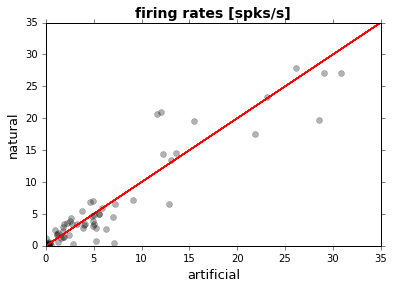

In [5]:
# Artificial
art_rates = dict()
for neuron_id in art_dat['spikes']:
    art_rates[neuron_id]=V4pyutils.get_firing_rate(art_dat['spikes'][neuron_id])

# Natural
nat_rates = dict()
for neuron_id in nat_dat['spikes']:
    nat_rates[neuron_id]=V4pyutils.get_firing_rate(nat_dat['spikes'][neuron_id])

# Plot artificial vs. natural firing rates
plt.figure()
for i in art_rates:
    plt.plot([0,35],[0,35],'r')
    plt.plot(art_rates[i], nat_rates[i],'ko', alpha=0.3)
    plt.xlabel('artificial')
    plt.ylabel('natural')
    plt.title('firing rates [spks/s]')
plt.show()

# Print the firing rates side by aside
#for i in art_rates:
#    print '%s art:%.2f, nat:%.2f' % (i, art_rates[i], nat_rates[i])

## Explore data by visualizing PSTHs

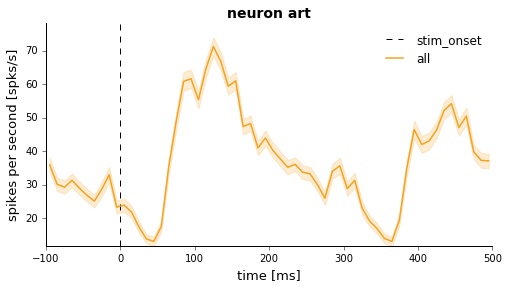

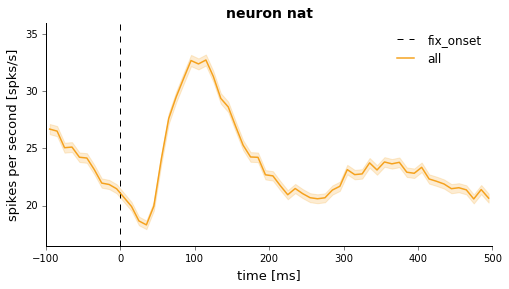

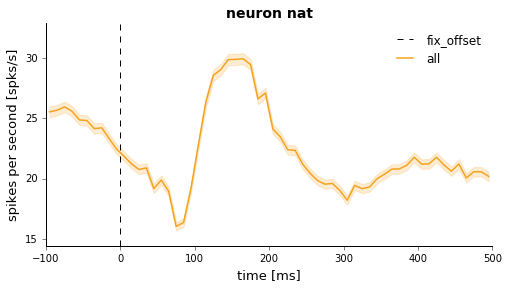

In [6]:
neuron_id = '0700'
#neuron_id = '5801'
#neuron_id = '0900'

art_neuron = NeuroVis(art_dat['spikes'][neuron_id], name='art')
nat_neuron = NeuroVis(nat_dat['spikes'][neuron_id], name='nat')

art_events = dict()
art_events['stim_onset'] = np.array([art_dat['eyes'][i]['stim_onset'] for i in art_dat['eyes']])
art_events['stim_offset'] = np.array([art_dat['eyes'][i]['stim_offset'] for i in art_dat['eyes']])

psth = art_neuron.get_psth(events=art_events['stim_onset'], plot=False);
art_neuron.plot_psth(psth=psth, event_name='stim_onset');

nat_events = dict()
nat_events['fix_onset'] = np.array([nat_dat['eyes'][i]['fix_onset'] for i in nat_dat['eyes']])
nat_events['fix_offset'] = np.array([nat_dat['eyes'][i]['fix_offset'] for i in nat_dat['eyes']])

psth = nat_neuron.get_psth(events=nat_events['fix_onset'], plot=False);
nat_neuron.plot_psth(psth=psth, event_name='fix_onset');

psth = nat_neuron.get_psth(events=nat_events['fix_offset'], plot=False);
nat_neuron.plot_psth(psth=psth, event_name='fix_offset');

## Get features (X)

In [16]:
params = dict()
params['n_bins'] = 16
params['window'] = [50, 300]
params['radius'] = 200
params['n_patches'] = 16
params['n_blocks'] = np.int(np.sqrt(params['n_patches']))
params['selected_neuron'] = '0900'
params['stimpath'] = '../V4pydata'

### artificial features

In [8]:
# Collect features of interest into a dict
features_art = dict()
features_art['col'] = np.array([art_dat['eyes'][i]['col'] for i in art_dat['eyes']])
features_art['row'] = np.array([art_dat['eyes'][i]['col'] for i in art_dat['eyes']])
features_art['hue'] = np.array([art_dat['features'][i]['hue'] for i in art_dat['features']])
features_art['onset_times'] = np.array([art_dat['events'][i]['onset'] for i in art_dat['events']])
offset_times = np.array([art_dat['events'][i]['offset'] for i in art_dat['events']])
onset_times = np.array([art_dat['events'][i]['onset'] for i in art_dat['events']])
features_art['off_to_onset_times']=onset_times-np.roll(offset_times,1)

In [9]:
# Extract hue
hue = features_art['hue']

In [10]:
# Encode hue histogram as one-hot vector
Xart = V4pyutils.onehothue(hue, n_bins=params['n_bins'])

### natural features

In [11]:
# Extract a patch of arbitrary radius around a fixation and compute hue histograms

stimpath = params['stimpath']
R = params['radius']
n_patches = params['n_patches']
n_blocks = params['n_blocks']

# List of included fixations
fixation_list = list()

# Dictionaries for real and shuffled control features
Xnat = dict()
Xnat_shuf = dict()

#Grid patches
for grd in np.arange(n_patches): 
    Xnat[grd] = []
    Xnat_shuf[grd] = []

for fx in range(len(nat_dat['eyes'])):
    if fx%1000==0:
        print fx

    # Read in the image and shuffle image
    if (fx > 0 and nat_dat['eyes'][fx]['imname'] != nat_dat['eyes'][fx-1]['imname']) or fx == 0:
        I = V4pyutils.get_image(nat_dat['eyes'][fx], stimpath)
        fx_rnd = np.random.randint(low=0, high=len(nat_dat['eyes']), size=1)[0]
        Ishuf = V4pyutils.get_image(nat_dat['eyes'][fx_rnd], stimpath)

    # Get gaze location
    r = nat_dat['eyes'][fx]['row']
    c = nat_dat['eyes'][fx]['col']
    
    #If gaze is within the image borders
    if (nat_dat['eyes'][fx]['row'] > R) and \
        (nat_dat['eyes'][fx]['row'] < (768 - R)) and \
        (nat_dat['eyes'][fx]['col'] > R) and \
        (nat_dat['eyes'][fx]['col'] < (1024 - R)) \
        and (not np.isnan(r)) and (not np.isnan(c)):
        
        r = int(r)
        c = int(c)
        
        # Extract patches
        G = I[r-R:r+R, c-R:c+R, :]
        Gshuf = Ishuf[r-R:r+R, c-R:c+R, :]
        
        # Divide it into grids    
        G_block = V4pyutils.grid_image(G, [n_blocks, n_blocks])
        for grd in range(0, n_patches):
            hue = V4pyutils.get_hue_image(G_block[grd,:,:,:])
            Xnat[grd].append(V4pyutils.bin_it(hue, params))
        
        
        Gshuf_block = V4pyutils.grid_image(Gshuf, [n_blocks, n_blocks])
        for grd in range(0, n_patches):
            hue = V4pyutils.get_hue_image(Gshuf_block[grd,:,:,:])
            Xnat_shuf[grd].append(V4pyutils.bin_it(hue, params))

        fixation_list.append(fx)
        
    #else:
        #print r,c
        #print 'outside'

for grd in range(0, 16):
    Xnat[grd] = np.array(Xnat[grd])
    Xnat_shuf[grd] = np.array(Xnat_shuf[grd])

0


KeyboardInterrupt: 

In [20]:
#dd.io.save('Xnat.h5', Xnat)
#dd.io.save('Xnat_shuf.h5', Xnat_shuf)
#dd.io.save('fixation_list.h5', fixation_list)

In [21]:
fixation_list = dd.io.load('fixation_list.h5')
Xnat = dd.io.load('Xnat.h5')
Xnat_shuf = dd.io.load('Xnat_shuf.h5')

## Get spike counts (Y)

### artificial

In [22]:
# Get number of samples and neurons
n_samples = len(art_dat['events'])
n_neurons = len(art_dat['spikes'].keys())

# Initialize spikecounts vector
Yart = dict()
for neuron_id in art_dat['spikes'].keys():
    # Extract spiketimes for a given neuron
    spiketimes = art_dat['spikes'][neuron_id]
    
    # Extract spikecounts
    if len(spiketimes) > 1:
        neuron = NeuroVis(spiketimes, name=neuron_id)
        Yart[neuron_id] = neuron.get_spikecounts(features_art['onset_times'], window=params['window'])
    else:
        Yart[neuron_id] = np.zeros(n_samples)

### natural

In [23]:
features_nat = dict()
features_nat['valid_fix_onset'] = np.array([nat_dat['eyes'][i]['fix_onset'] for i in fixation_list])

In [24]:
# Initialize spikecounts vector
Ynat = dict()

# Only collect spikecounts for included fixations
n_samples = len(fixation_list)

for neuron_id in nat_dat['spikes'].keys():
    # Extract spiketimes for a given neuron
    spiketimes = nat_dat['spikes'][neuron_id]
    
    if len(spiketimes) > 1:
        # Extract spikecounts
        neuron = NeuroVis(spiketimes, name=neuron_id)
        Ynat[neuron_id] = neuron.get_spikecounts(features_nat['valid_fix_onset'], window=params['window'])
    else:
        Ynat[neuron_id] = np.zeros(n_samples)

### sanity check: print shapes of data

In [25]:
selected_neuron = params['selected_neuron']
print "Xart (%d, %d) Yart (%d, )" % (np.shape(Xart)[0], np.shape(Xart)[1], np.shape(Yart[selected_neuron])[0])
print "Xnat (%d, %d) Ynatt (%d, )" % (np.shape(Xnat[0])[0], np.shape(Xnat[0])[1], np.shape(Ynat[selected_neuron])[0])

Xart (673, 16) Yart (673, )
Xnat (7575, 16) Ynatt (7575, )


## Model fitting

In [26]:
selected_neuron = params['selected_neuron']

### fit art

In [27]:
Yt_art_hat, PR2_art = V4pyutils.fit_cv(Xart, Yart[selected_neuron], algorithm = 'XGB_poisson', silent = 0)
Yt_art_hat, PR2_art = V4pyutils.fit_cv(features_art['hue'], Yart[selected_neuron], algorithm = 'XGB_poisson', silent = 0)

...runnning cv-fold 1 of 10
pR2:  0.380695484672
...runnning cv-fold 2 of 10
pR2:  0.510293471395
...runnning cv-fold 3 of 10
pR2:  0.366918188748
...runnning cv-fold 4 of 10
pR2:  0.471020290456
...runnning cv-fold 5 of 10
pR2:  0.432016164598
...runnning cv-fold 6 of 10
pR2:  0.371806844327
...runnning cv-fold 7 of 10
pR2:  0.476967393281
...runnning cv-fold 8 of 10
pR2:  0.297240403971
...runnning cv-fold 9 of 10
pR2:  0.122121655305
...runnning cv-fold 10 of 10
pR2:  0.555324048637
pR2_cv: 0.398440 (+/- 0.037188)
...runnning cv-fold 1 of 10
pR2:  0.40958342463
...runnning cv-fold 2 of 10
pR2:  0.530619030204
...runnning cv-fold 3 of 10
pR2:  0.404749017458
...runnning cv-fold 4 of 10
pR2:  0.533758132041
...runnning cv-fold 5 of 10
pR2:  0.419225975569
...runnning cv-fold 6 of 10
pR2:  0.387506616223
...runnning cv-fold 7 of 10
pR2:  0.450618981453
...runnning cv-fold 8 of 10
pR2:  0.266036195477
...runnning cv-fold 9 of 10
pR2:  0.140366430218
...runnning cv-fold 10 of 10
pR2:  0.

### fit nat

In [28]:
Yt_nat_hat = dict()
PR2_nat = dict()
for patch_n in np.arange(params['n_patches']):
    Yt_nat_hat[patch_n], PR2_nat[patch_n] = V4pyutils.fit_cv(Xnat[patch_n], 
                                                             Ynat[selected_neuron], 
                                                             algorithm = 'XGB_poisson',
                                                             silent = 1)
    
    print 'patch %d: pseudo-R2: %.4f +- %.4f' % (patch_n, np.mean(PR2_nat[patch_n]), 
                                                 np.std(PR2_nat[patch_n])/np.sqrt(np.size(PR2_nat[patch_n])))

patch 0: pseudo-R2: 0.0025 +- 0.0030
patch 1: pseudo-R2: 0.0026 +- 0.0031
patch 2: pseudo-R2: -0.0037 +- 0.0036
patch 3: pseudo-R2: -0.0022 +- 0.0042
patch 4: pseudo-R2: 0.0099 +- 0.0046
patch 5: pseudo-R2: 0.0122 +- 0.0041
patch 6: pseudo-R2: 0.0043 +- 0.0055
patch 7: pseudo-R2: -0.0015 +- 0.0047
patch 8: pseudo-R2: 0.0072 +- 0.0041
patch 9: pseudo-R2: 0.0224 +- 0.0034
patch 10: pseudo-R2: 0.0301 +- 0.0048
patch 11: pseudo-R2: 0.0076 +- 0.0039
patch 12: pseudo-R2: 0.0139 +- 0.0057
patch 13: pseudo-R2: 0.0398 +- 0.0056
patch 14: pseudo-R2: 0.0597 +- 0.0060
patch 15: pseudo-R2: 0.0347 +- 0.0049


### fit nat shuffled

In [29]:
Yt_nat_hat_shuf = dict()
PR2_nat_shuf = dict()
for patch_n in np.arange(params['n_patches']):
    Yt_nat_hat_shuf[patch_n], PR2_nat_shuf[patch_n] = V4pyutils.fit_cv(Xnat_shuf[patch_n], 
                                                             Ynat[selected_neuron], 
                                                             algorithm = 'XGB_poisson',
                                                             silent = 1)
    
    print 'patch %d: pseudo-R2: %.2f +- %.2f' % (patch_n, np.mean(PR2_nat_shuf[patch_n]), 
                                                 np.std(PR2_nat_shuf[patch_n])/np.sqrt(np.size(PR2_nat_shuf)))

patch 0: pseudo-R2: -0.01 +- 0.01
patch 1: pseudo-R2: -0.01 +- 0.01
patch 2: pseudo-R2: -0.02 +- 0.01
patch 3: pseudo-R2: -0.01 +- 0.01
patch 4: pseudo-R2: -0.01 +- 0.01
patch 5: pseudo-R2: -0.01 +- 0.01
patch 6: pseudo-R2: -0.01 +- 0.01
patch 7: pseudo-R2: -0.01 +- 0.01
patch 8: pseudo-R2: -0.02 +- 0.01
patch 9: pseudo-R2: -0.01 +- 0.02
patch 10: pseudo-R2: -0.01 +- 0.01
patch 11: pseudo-R2: -0.01 +- 0.01
patch 12: pseudo-R2: -0.01 +- 0.02
patch 13: pseudo-R2: -0.01 +- 0.01
patch 14: pseudo-R2: -0.02 +- 0.02
patch 15: pseudo-R2: -0.01 +- 0.01


## Visualization

### art

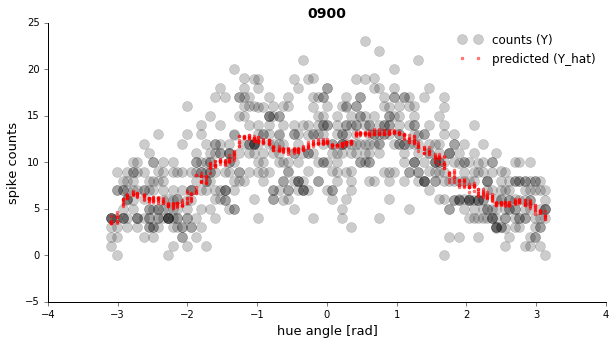

In [30]:
plt.figure(figsize=(10,5))
plt.title(params['selected_neuron'], {'fontsize': 14})


plt.plot(features_art['hue'], Yart[selected_neuron] + 0.01*np.random.normal(size=np.size(features_art['hue'])),
         'k.', alpha=0.2, markersize=20)

plt.plot(features_art['hue'], Yt_art_hat, 'r.', alpha = 0.5)
plt.xlabel('hue angle [rad]')
plt.ylabel('spike counts')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')

plt.legend(['counts (Y)','predicted (Y_hat)'], frameon=False)
plt.show()


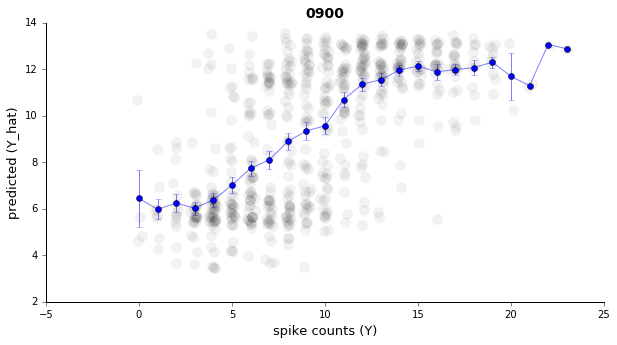

In [31]:
plt.figure(figsize=(10,5))
plt.title(params['selected_neuron'], {'fontsize': 14})


plt.plot(Yart[selected_neuron] + 0.1*np.random.normal(size=np.size(features_art['hue'])),
         Yt_art_hat, 
         'k.', alpha=0.05, markersize=20)

meanYhat = list()
semYhat = list()
unique_counts = np.unique(Yart[selected_neuron])

for i in unique_counts:
    loc = np.where(Yart[selected_neuron]==i)[0]
    meanYhat.append(np.mean(Yt_art_hat[loc]))
    semYhat.append(np.std(Yt_art_hat[loc])/np.sqrt(len(loc)))

plt.errorbar(np.unique(Yart[selected_neuron]),meanYhat,yerr=np.array(semYhat), alpha=0.5)
plt.plot(np.unique(Yart[selected_neuron]),meanYhat,'bo')

plt.ylabel('predicted (Y_hat)')
plt.xlabel('spike counts (Y)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.show()

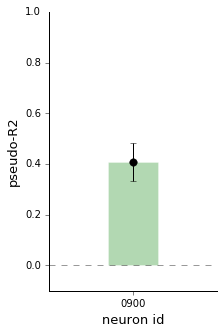

In [32]:
mean_pR2 = np.mean(PR2_art)
sem_pR2 = np.std(PR2_art)/np.sqrt(np.size(PR2_art))

plt.figure(figsize=(3,5))
plt.plot([-1,1],[0,0],'--k', alpha=0.4)
#plt.plot([0.2,0.2],[0,65],'--k', alpha=0.3)
#plt.plot([0.4,0.4],[0,65],'--k', alpha=0.3)

plt.bar(np.arange(np.size(mean_pR2)), mean_pR2, 0.6, align='center', 
        ecolor='k', alpha=0.3, color='g', ec='w', yerr=1.96*np.array(sem_pR2), 
        tick_label=selected_neuron)
plt.plot(np.arange(np.size(mean_pR2)), mean_pR2, 'k.', markersize=15)
plt.xlim([-1,1])
plt.ylim([-0.1,1.0])

plt.xlabel('neuron id')
plt.ylabel('pseudo-R2')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.show()

### nat

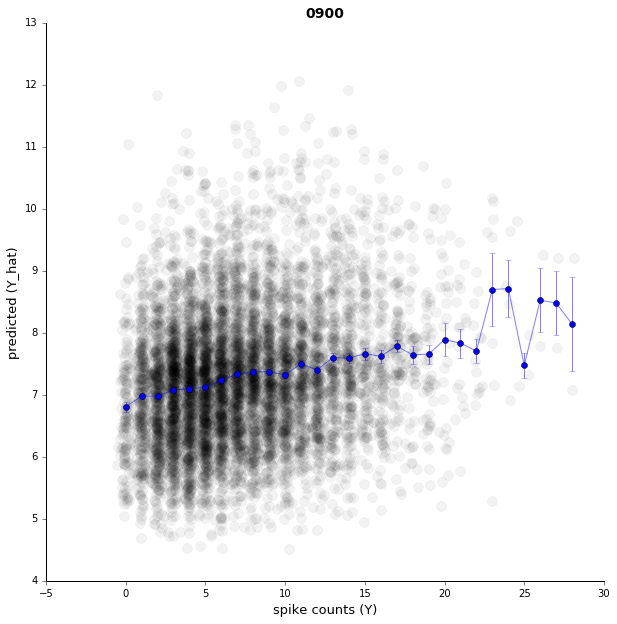

In [33]:
patch_n = 13

plt.figure(figsize=(10,10))
plt.title(params['selected_neuron'], {'fontsize': 14})

plt.plot(Ynat[selected_neuron] + 0.2*np.random.normal(size=np.size(Ynat[selected_neuron])),
         Yt_nat_hat[patch_n], 
         'k.', alpha=0.05, markersize=20)

meanYhat = list()
semYhat = list()
unique_counts = np.unique(Ynat[selected_neuron])

for i in unique_counts:
    loc = np.where(Ynat[selected_neuron]==i)[0]
    meanYhat.append(np.mean(Yt_nat_hat[patch_n][loc]))
    semYhat.append(np.std(Yt_nat_hat[patch_n][loc])/np.sqrt(len(loc)))

plt.errorbar(np.unique(Ynat[selected_neuron]),meanYhat,yerr=np.array(semYhat), alpha=0.5)
plt.plot(np.unique(Ynat[selected_neuron]),meanYhat,'bo')

plt.ylabel('predicted (Y_hat)')
plt.xlabel('spike counts (Y)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.show()

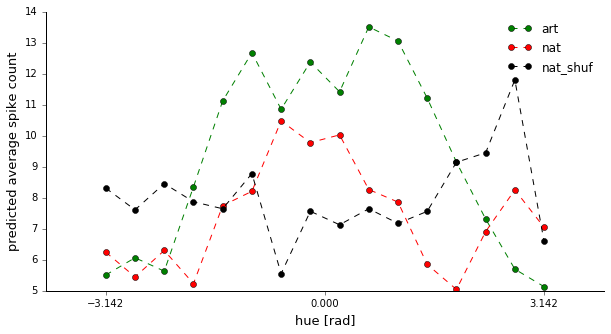

In [39]:
hue_line = np.linspace(-np.pi, np.pi, 16)
Xart_line = V4pyutils.onehothue(hue_line, n_bins=16)
patch_n=10

Yline_nat_hat = V4pyutils.XGB_poisson(Xnat[patch_n], Ynat[selected_neuron], Xart_line)
Yline_nat_shuf_hat = V4pyutils.XGB_poisson(Xnat_shuf[patch_n], Ynat[selected_neuron], Xart_line)
Yline_art_hat = V4pyutils.XGB_poisson(Xart, Yart[selected_neuron], Xart_line)

plt.figure(figsize=(10,5))
plt.plot(hue_line, Yline_art_hat,'o--g')
plt.plot(hue_line, Yline_nat_hat,'o--r')
plt.plot(hue_line, Yline_nat_shuf_hat,'o--k')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.ylabel('predicted average spike count')
plt.xlabel('hue [rad]')
plt.xticks(np.linspace(-np.pi,np.pi,3))
plt.legend(['art', 'nat', 'nat_shuf'],frameon= False)
plt.show()

In [36]:
def run_synthetic(X, Y, hue_line, verbose = 1):
    Xart_line = V4pyutils.onehothue(hue_line, n_bins=16)
    Yline_hat = dict()
    
    for patch_n in X:
        if verbose:
            print 'running %d of %d' % (patch_n+1, len(X))
        Yline_hat[patch_n] = V4pyutils.XGB_poisson(X[patch_n], Y, Xart_line)
    
    return Yline_hat

In [37]:
Yline_nat_hat  = run_synthetic(Xnat, Ynat[selected_neuron], hue_line, verbose=0)
Yline_nat_shuf_hat  = run_synthetic(Xnat_shuf, Ynat[selected_neuron], hue_line, verbose=0)

Yline_art_hat = V4pyutils.XGB_poisson(Xart, Yart[selected_neuron], Xart_line)

/home/klab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ValueError: x and y must have same first dimension

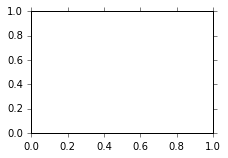

In [45]:
plt.figure(figsize=(15,10))
for patch_n in Yline_nat_hat:
    plt.subplot(4,4,patch_n+1)
    plt.plot(hue_line, Yline_nat_hat[patch_n],'.-r')
    plt.plot(hue_line, Yline_nat_shuf_hat[patch_n],'.-k')
    #plt.plot(hue_line, Yline_art_hat,'.-g')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    if patch_n%4==0:
        plt.ylabel('predicted')
    if patch_n>11:
        plt.xlabel('hue [rad]')
    plt.xticks(np.linspace(-np.pi,np.pi,3), ['-pi','0','pi'])
    #plt.legend(['art', 'nat', 'nat_shuf'],frameon= False)
    plt.ylim([3,13])
plt.show()

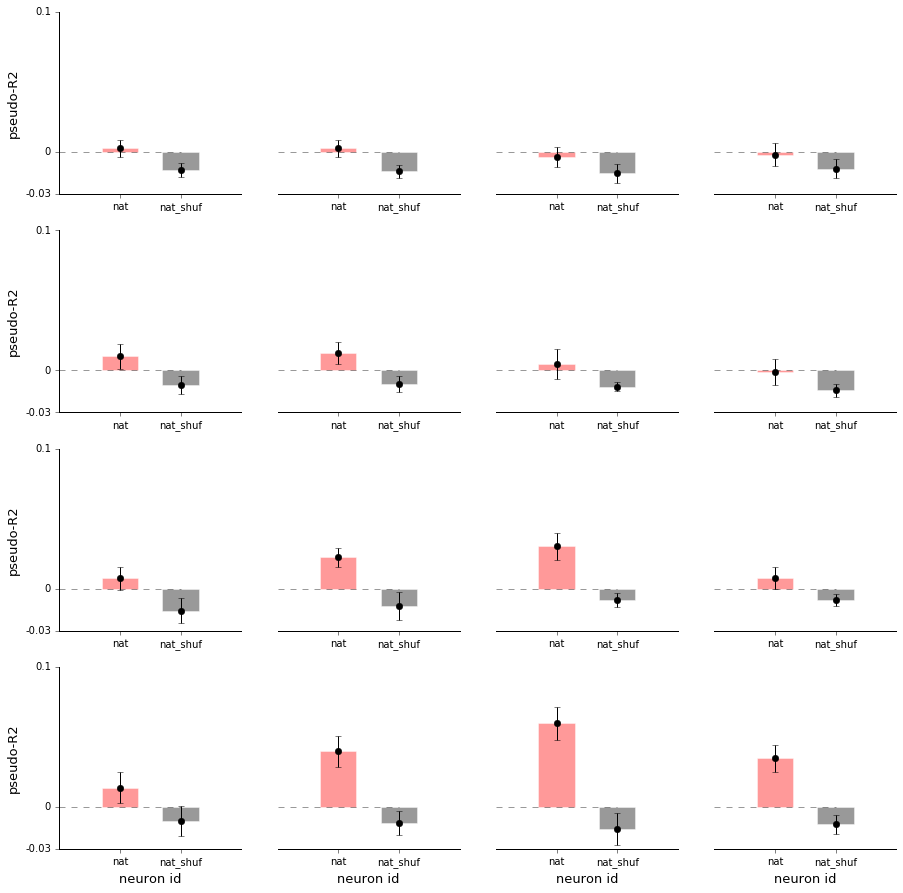

In [40]:
plt.figure(figsize=(15,15))
plt.title('neuron %s' % selected_neuron)
ylim = [-0.03,0.1]
for patch_n in PR2_nat:
    mean_pR2 = np.mean(PR2_nat[patch_n])
    sem_pR2 = np.std(PR2_nat[patch_n])/np.sqrt(np.size(PR2_nat[patch_n]))
    mean_pR2_shuf = np.mean(PR2_nat_shuf[patch_n])
    sem_pR2_shuf = np.std(PR2_nat_shuf[patch_n])/np.sqrt(np.size(PR2_nat_shuf[patch_n]))

    plt.subplot(4,4,patch_n+1)

    plt.bar([0,1], [mean_pR2, mean_pR2_shuf], 0.6, align='center', 
            ecolor='k', alpha=0.4, color=['r','k'], ec='w', yerr=1.96*np.array([sem_pR2, sem_pR2_shuf]), 
            tick_label=['nat','nat_shuf'])
    
    plt.plot([-1,1],[0,0],'--k', alpha=0.4)
    plt.plot([0,1], [mean_pR2, mean_pR2_shuf], '.', c='k', markersize=13)
    plt.xlim([-1,2])
   
    plt.ylim(ylim)
    
    ax = plt.gca()
    
    if patch_n>11:
        plt.xlabel('neuron id')
    if patch_n%4==0:
        plt.ylabel('pseudo-R2')
        plt.yticks([ylim[0],0,ylim[1]],[ylim[0],'0',ylim[1]])
    if patch_n%4>0:
        ax.spines['left'].set_visible(False)
        plt.yticks(ylim,['',''])
        plt.tick_params(axis='y', left='off')
     
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')

plt.show()